In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

def extract_labels(labels):
    # Map emotion labels to integers
    label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
    return np.array([label_mapping[label] for label in labels])

class EmotionDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.data, self.labels = self.load_data(dataset_path)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    @staticmethod
    def load_data(dataset_path):
        data = []
        labels = []

        for emotion_folder in os.listdir(dataset_path):
            emotion_path = os.path.join(dataset_path, emotion_folder)
            for img_name in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_name)
                img = cv2.imread(img_path)
                data.append(img)
                labels.append(emotion_folder)

        return np.array(data), extract_labels(labels)
    
    


In [2]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
train_path = 'FER2013/train'
absolute_train_path = os.path.abspath(train_path)

test_path = 'FER2013/test'
absolute_test_path = os.path.abspath(test_path)

train_dataset = EmotionDataset(absolute_train_path, transform=transform)
test_dataset = EmotionDataset(absolute_test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Load pre-trained model

In [4]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda") # Use the GPU for computation
    print("Using GPU for computation!")
else:
    device = torch.device("cpu") # Use the CPU for computation
    print("Using CPU for computation!")

Using GPU for computation!


In [5]:
from torchvision import transforms, models

model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 7)  

C:\Users\zyz20\anaconda3\envs\gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zyz20\anaconda3\envs\gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
if torch.cuda.is_available():
    model.to('cuda')
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to('cuda')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: cuda


Define Loss function and optimiztion

In [8]:
# Modify the loss function and optimizer to work with GPU
criterion = criterion.to(device)

In [11]:
def testset(model, test_loader, device):
    model.eval()
    test_accuracy = 0  
    num_correct = 0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            num_correct += (preds == labels).sum()
            num_samples += labels.size(0)
            acc = float(num_correct) / num_samples
            test_accuracy += acc
    
    print(f'Test Accuracy: {test_accuracy / len(test_loader):.4f}')
    return test_accuracy / len(test_loader)

In [12]:
num_epochs = 30
training_Acc = []
testing_Acc = []

for epoch in range(num_epochs):

    model.train()
    
    train_accuracy = 0
    num_correct = 0
    num_samples = 0
    
    for inputs, labels in train_loader: 
     
        optimizer.zero_grad()
        
        # Forward pass
        inputs = inputs.to(device) 
        labels = labels.long().to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        num_correct += (preds == labels).sum()
        num_samples += labels.size(0)
        acc = float(num_correct) / num_samples
        train_accuracy += acc
        
    # Print epoch loss and accuracy
    avg_acc = train_accuracy / len(train_loader)     
    training_Acc.append(avg_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {avg_acc:.4f}')
    test_acc = testset(model, test_loader, device)
    test_acc.append(test_acc)

Epoch 1/30, Loss: 1.0782, Accuracy: 0.5636
Test Accuracy: 0.5836
Epoch 2/30, Loss: 1.7656, Accuracy: 0.6175
Test Accuracy: 0.6197
Epoch 3/30, Loss: 0.9831, Accuracy: 0.6604
Test Accuracy: 0.6213
Epoch 4/30, Loss: 2.5608, Accuracy: 0.7132
Test Accuracy: 0.6446
Epoch 5/30, Loss: 0.6431, Accuracy: 0.7751
Test Accuracy: 0.6189
Epoch 6/30, Loss: 0.8079, Accuracy: 0.8504
Test Accuracy: 0.6452
Epoch 7/30, Loss: 0.5118, Accuracy: 0.9110
Test Accuracy: 0.6236
Epoch 8/30, Loss: 0.8914, Accuracy: 0.9362
Test Accuracy: 0.6259
Epoch 9/30, Loss: 0.7137, Accuracy: 0.9485
Test Accuracy: 0.6401
Epoch 10/30, Loss: 0.0042, Accuracy: 0.9598
Test Accuracy: 0.6427
Epoch 11/30, Loss: 0.7634, Accuracy: 0.9701
Test Accuracy: 0.6244
Epoch 12/30, Loss: 0.0173, Accuracy: 0.9635
Test Accuracy: 0.6171
Epoch 13/30, Loss: 0.5353, Accuracy: 0.9756
Test Accuracy: 0.6269
Epoch 14/30, Loss: 0.0015, Accuracy: 0.9728
Test Accuracy: 0.6288
Epoch 15/30, Loss: 0.0068, Accuracy: 0.9744
Test Accuracy: 0.6298
Epoch 16/30, Loss: 

In [13]:
for inputs, labels in train_loader:

    print(type(inputs))
    print(type(labels))
    print(inputs)
    print(labels)
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([[[[-1.1418, -1.1418, -1.1418,  ..., -1.5014, -1.5014, -1.5014],
          [-1.1418, -1.1418, -1.1418,  ..., -1.5014, -1.5014, -1.5014],
          [-1.1418, -1.1418, -1.1418,  ..., -1.5014, -1.5014, -1.5014],
          ...,
          [-0.6109, -0.6109, -0.6109,  ..., -1.6727, -1.6727, -1.6727],
          [-0.6109, -0.6109, -0.6109,  ..., -1.6727, -1.6727, -1.6727],
          [-0.6109, -0.6109, -0.6109,  ..., -1.6727, -1.6727, -1.6727]],

         [[-1.0378, -1.0378, -1.0378,  ..., -1.4055, -1.4055, -1.4055],
          [-1.0378, -1.0378, -1.0378,  ..., -1.4055, -1.4055, -1.4055],
          [-1.0378, -1.0378, -1.0378,  ..., -1.4055, -1.4055, -1.4055],
          ...,
          [-0.4951, -0.4951, -0.4951,  ..., -1.5805, -1.5805, -1.5805],
          [-0.4951, -0.4951, -0.4951,  ..., -1.5805, -1.5805, -1.5805],
          [-0.4951, -0.4951, -0.4951,  ..., -1.5805, -1.5805, -1.5805]],

         [[-0.8110, -0.8110, -0.8110,  ..., -1.1770, -1.

In [14]:
test_acc = testset(model, test_loader, device)

Test Accuracy: 0.6338


In [15]:
torch.save(model.state_dict(), "model_resNet_30.pth")

In [17]:
pip install matplotlib

     ---------------------------------------- 0.0/159.4 kB ? eta -:--:--
     ---------- ---------------------------- 41.0/159.4 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 159.4/159.4 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.6 MB 26.1 MB/s eta 0:00:01
   --------- ------------------------------ 1.9/7.6 MB 24.3 MB/s eta 0:00:01
   --------------- ------------------------ 3.0/7.6 MB 27.4 MB/s eta 0:00:01
   --------------------- ------------------ 4.2/7.6 MB 29.8 MB/s eta 0:00:01
   ----------------------------- ---------- 5.7/7.6 MB 33.0 MB/s eta 0:00:01
   ---------------------------------- ----- 6.6/7.6 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 32.6 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 28.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/187.6 kB ? eta -:--:--
   --------

In [51]:
all_Acc = [0.5636314717673848, 0.5836136164896241, 0.6174562843949275, 0.6197063476244206, 0.6603723361335236, 0.6212629145704025, 0.7132108466429967, 0.6446352460895072, 0.7750882347975762, 0.6189187223940336, 0.8504211944642124, 0.6452192858416684, 0.9109559541113386, 0.6236099737190816, 0.9361894091700133, 0.6259083645941659, 0.9484669176284564, 0.6401118230402272, 0.9597575340766834, 0.6427015010232215, 0.9701111394115421, 0.6244017076064257, 0.9635008634525782, 0.6170680166290606, 0.9756045994649154, 0.626939693340432, 0.9727549371395686, 0.6288275773089834, 0.9743872125487453, 0.6297563431664677, 0.9748447000587227, 0.6260920734737813, 0.9730417686687344, 0.6309746418148853, 0.9800600301685125, 0.6294837093999593, 0.9837244491510141, 0.6255004207973228, 0.9833368158005823, 0.6317321023234482, 0.9772059718514434, 0.6353557633209429, 0.9847459519567424, 0.6194297429131613, 0.9867771864629076, 0.6285464872608135, 0.9816603363010203, 0.6467998145129527, 0.9846935601693854, 0.6228826280184437, 0.9868339785379776, 0.6256364839672094, 0.9759466270091814, 0.6438147844143447, 0.9883029944009419, 0.6356899261917061, 0.9866099325984107, 0.6266016924789561, 0.9822640923638776, 0.6322634904219054]

In [52]:
test_Acc = []
tranning_Acc = []

i = 0
while i < len(all_Acc):
    tranning_Acc.append(all_Acc[i])
    i += 1
    test_Acc.append(all_Acc[i])
    i += 1

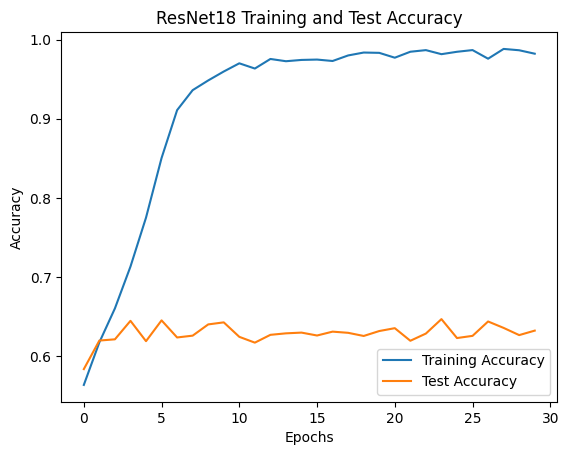

In [62]:
import matplotlib.pyplot as plt

training_Acc = [0.5636314717673848, 0.6174562843949275, 0.6603723361335236, 0.7132108466429967, 0.7750882347975762, 0.8504211944642124, 0.9109559541113386, 0.9361894091700133, 0.9484669176284564, 0.9597575340766834, 0.9701111394115421, 0.9635008634525782, 0.9756045994649154, 0.9727549371395686, 0.9743872125487453, 0.9748447000587227, 0.9730417686687344, 0.9800600301685125, 0.9837244491510141, 0.9833368158005823, 0.9772059718514434, 0.9847459519567424, 0.9867771864629076, 0.9816603363010203, 0.9846935601693854, 0.9868339785379776, 0.9759466270091814, 0.9883029944009419, 0.9866099325984107, 0.9822640923638776]

test_Acc = [0.5836136164896241, 0.6197063476244206, 0.6212629145704025, 0.6446352460895072, 0.6189187223940336, 0.6452192858416684, 0.6236099737190816, 0.6259083645941659, 0.6401118230402272, 0.6427015010232215, 0.6244017076064257, 0.6170680166290606, 0.626939693340432, 0.6288275773089834, 0.6297563431664677, 0.6260920734737813, 0.6309746418148853, 0.6294837093999593, 0.6255004207973228, 0.6317321023234482, 0.6353557633209429, 0.6194297429131613, 0.6285464872608135, 0.6467998145129527, 0.6228826280184437, 0.6256364839672094, 0.6438147844143447, 0.6356899261917061, 0.6266016924789561, 0.6322634904219054]

plt.plot(training_Acc, label='Training Accuracy')
plt.plot(test_Acc, label='Test Accuracy')

plt.title('ResNet18 Training and Test Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [54]:
len(tranning_Acc)

30

In [55]:
len(test_Acc)

30

In [56]:
tranning_Acc

[0.5636314717673848,
 0.6174562843949275,
 0.6603723361335236,
 0.7132108466429967,
 0.7750882347975762,
 0.8504211944642124,
 0.9109559541113386,
 0.9361894091700133,
 0.9484669176284564,
 0.9597575340766834,
 0.9701111394115421,
 0.9635008634525782,
 0.9756045994649154,
 0.9727549371395686,
 0.9743872125487453,
 0.9748447000587227,
 0.9730417686687344,
 0.9800600301685125,
 0.9837244491510141,
 0.9833368158005823,
 0.9772059718514434,
 0.9847459519567424,
 0.9867771864629076,
 0.9816603363010203,
 0.9846935601693854,
 0.9868339785379776,
 0.9759466270091814,
 0.9883029944009419,
 0.9866099325984107,
 0.9822640923638776]

In [57]:
test_Acc

[0.5836136164896241,
 0.6197063476244206,
 0.6212629145704025,
 0.6446352460895072,
 0.6189187223940336,
 0.6452192858416684,
 0.6236099737190816,
 0.6259083645941659,
 0.6401118230402272,
 0.6427015010232215,
 0.6244017076064257,
 0.6170680166290606,
 0.626939693340432,
 0.6288275773089834,
 0.6297563431664677,
 0.6260920734737813,
 0.6309746418148853,
 0.6294837093999593,
 0.6255004207973228,
 0.6317321023234482,
 0.6353557633209429,
 0.6194297429131613,
 0.6285464872608135,
 0.6467998145129527,
 0.6228826280184437,
 0.6256364839672094,
 0.6438147844143447,
 0.6356899261917061,
 0.6266016924789561,
 0.6322634904219054]

In [63]:
test_acc = testset(model, test_loader, device)

Test Accuracy: 0.6358
